# 파일 로드

In [2]:
import os
import re
from typing import List, Dict, Tuple

def load_markdown_files(directory_path: str) -> Dict[str, str]:
    md_files_content = {}
    if not os.path.exists(directory_path) :
        print(f"디렉토리 '{directory_path}를 로드할 수 없습니다.")
        return md_files_content
    
    for filename in os.listdir(directory_path) :
        if filename.endswith(".md") :
            filepath = os.path.join(directory_path, filename)
            try :
                with open(filepath, 'r', encoding="utf-8") as f :
                    md_files_content[filepath] = f.read()
            except Exception as e :
                print(f"파일 {filepath} 로드 중 오류 : {e}")
    return md_files_content

In [3]:
MD_FILES_DIR = "./data/split_file/anatomy"
all_md_contents = load_markdown_files(MD_FILES_DIR)

if all_md_contents :
    for i, contents in enumerate(all_md_contents) :
        filename = list(all_md_contents.keys())[i]
        print(f"{i + 1}번째 파일 {filename} 일부 : ")
        print(all_md_contents[filename][:500])
        print("-" * 100)
else :
    print("마크다운 파일이 없습니다")

1번째 파일 ./data/split_file/anatomy/1_Embryology.md 일부 : 
#### Page 6
# I. Embryology

THE TERM Embryology, in its widest sense, is applied to the various changes which take place during the
growth of an animal from the egg to the adult condition: it is, however, usually restricted to the phenomena
which occur before birth. Embryology may be studied from two aspects: (1) that of ontogeny, which deals
only with the development of the individual; and (2) that of phylogeny, which concerns itself with the
evolutionary history of the animal kingdom.

In ver
----------------------------------------------------------------------------------------------------
2번째 파일 ./data/split_file/anatomy/2_Osteology.md 일부 : 
#### Page 37
# II. Osteology
T HE GENERA L framework of the body is built up mainly of a series of bones, supplemented, however, in
certain regions by pieces of cartilage; the bony part of the framework constitutes the skeleton.

In the skeleton of the adult there are 206 distinct bones, 

# Recursive chunking

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

def recursive_chunking(text: str, chunk_size: int, chunk_overlap: int) -> List[str] :
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False # seperators를 정규표현식으로 해석하지 않음(리터럴)
    )
    chunks = text_splitter.split_text(text)
    return chunks

recursive_chunks_results: Dict[str, List[str]] = {}
if all_md_contents :
    print("Recursive Chunking 시작")
    for filename, content in all_md_contents.items() :
        chunks = recursive_chunking(content, chunk_size = 1000, chunk_overlap = 200)
        recursive_chunks_results[filename] = chunks

    if recursive_chunks_results :
        first_file_name = list(recursive_chunks_results.keys())[0]
        print("첫번째 파일 청킹 결과 : ")
        for i, chunk in enumerate(recursive_chunks_results[first_file_name][:2]) :
            print(f"{i + 1} 번째 청크 : ")
            print(chunk)
            print("-" * 100)
        print("-" * 100)
else :
    print("마크다운 파일 없음")

Recursive Chunking 시작
첫번째 파일 청킹 결과 : 
1 번째 청크 : 
#### Page 6
# I. Embryology

THE TERM Embryology, in its widest sense, is applied to the various changes which take place during the
growth of an animal from the egg to the adult condition: it is, however, usually restricted to the phenomena
which occur before birth. Embryology may be studied from two aspects: (1) that of ontogeny, which deals
only with the development of the individual; and (2) that of phylogeny, which concerns itself with the
evolutionary history of the animal kingdom.
----------------------------------------------------------------------------------------------------
2 번째 청크 : 
In vertebrate animals the development of a new being can only take place when a female germ cell or
ovum has been fertilized by a male germ cell or spermatozoön. The ovum is a nucleated cell, and all the
complicated changes by which the various tissues and organs of the body are formed from it, after it has
been fertilized, are the result of tw

# 의미론적 청킹

In [5]:
from sentence_transformers import SentenceTransformer, util
from model_loader.config import *
import numpy as np

try :
    semantic_model = embedding_loader
except Exception as e :
    print(f"임베딩 모델 실행 중 오류 : {e}")

In [6]:
import torch

def semantic_chunking(text: str, model, threshold: float, min_chunk_size: int) -> List[str] :
    if model is None :
        return ["SentenceTransformer 모델이 로드되지 않음"]
    
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!|;|:)\s', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    if not sentences :
        return []
    
    embeddings = model.encode(sentences, convert_to_tensor=True)

    chunks = []
    current_chunk_sentences = [sentences[0]]
    current_chunk_embedding_sum = embeddings[0]
    current_chunk_count = 1

    for i in range(1, len(sentences)) :
        next_sentence = sentences[i]
        next_embedding = embeddings[i]

        avg_current_chunk_embedding = current_chunk_embedding_sum / current_chunk_count
        
        similarity = util.cos_sim(avg_current_chunk_embedding.unsqueeze(0), next_embedding.unsqueeze(0)).item()

        if similarity < threshold and len(" ".join(current_chunk_sentences)) >= min_chunk_size :
            chunks.append(" ".join(current_chunk_sentences))
            current_chunk_sentences = [next_sentence]
            current_chunk_embedding_sum = next_embedding
            current_chunk_count = 1
        else :
            current_chunk_sentences.append(next_sentence)
            current_chunk_embedding_sum += next_embedding
            current_chunk_count += 1

    if current_chunk_sentences :
        chunks.append(" ".join(current_chunk_sentences))

    return chunks

semantic_chunks_results: Dict[str, List[str]] = {}
if all_md_contents and semantic_model is not None :
    for filename, content in all_md_contents.items() :
        chunks = semantic_chunking(content, semantic_model, threshold=0.6, min_chunk_size=100)
        semantic_chunks_results[filename] = chunks

    if semantic_chunks_results :
        first_file_name = list(semantic_chunks_results.keys())[0]
        print(f"첫번째 파일 {first_file_name} 청킹 결과 : ")
        for i, chunk in enumerate(semantic_chunks_results[first_file_name][:2]) :
            print(f"--- 청크 {i+1} (길이 : {len(chunk)})")
            print(chunk)
            print("-" * 100)
        print("-" * 100)
else :
    print("마크다운 파일이 없거나 임베딩 모델이 없어 임베딩 청킹 불가")


첫번째 파일 ./data/split_file/anatomy/1_Embryology.md 청킹 결과 : 
--- 청크 1 (길이 : 189)
#### Page 6
# I. Embryology

THE TERM Embryology, in its widest sense, is applied to the various changes which take place during the
growth of an animal from the egg to the adult condition:
----------------------------------------------------------------------------------------------------
--- 청크 2 (길이 : 1549)
it is, however, usually restricted to the phenomena
which occur before birth. Embryology may be studied from two aspects: (1) that of ontogeny, which deals
only with the development of the individual; and (2) that of phylogeny, which concerns itself with the
evolutionary history of the animal kingdom. In vertebrate animals the development of a new being can only take place when a female germ cell or
ovum has been fertilized by a male germ cell or spermatozoön. The ovum is a nucleated cell, and all the
complicated changes by which the various tissues and organs of the body are formed from it, after it ha

# 고정 크기 청킹

In [7]:
from langchain_text_splitters import CharacterTextSplitter

def fixed_size_chunking(text: str, chunk_size: int=8000, chunk_overlap: int=200) -> List[str] :
    text_splitter = CharacterTextSplitter(
        separator="\n\n",
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False
    )

    chunks = text_splitter.split_text(text)
    return chunks

fixed_chunks_results: Dict[str, List[str]] = {}
if all_md_contents :
    for filename, content in all_md_contents.items() :
        chunks = fixed_size_chunking(content, chunk_size=1000, chunk_overlap=200)
        fixed_chunks_results[filename] = chunks
        print(f"{filename} : {len(chunks)}개의 청크 생성")

    if fixed_chunks_results :
        first_file_name = list(fixed_chunks_results.keys())[0]
        print(f"첫번째 파일 {first_file_name}의 고정 크기 청킹 결과")
        for i, chunk in enumerate(fixed_chunks_results[first_file_name][:2]) :
            print(f"청크 {i + 1} 길이 : {len(chunk)}")
            print(chunk)
            print('-' * 100)
        print('-' * 100)
else :
    print("로드된 마크다운 파일이 없어 고정 크기 청킹 수행 불가")

Created a chunk of size 2083, which is longer than the specified 1000
Created a chunk of size 1618, which is longer than the specified 1000
Created a chunk of size 1122, which is longer than the specified 1000
Created a chunk of size 1029, which is longer than the specified 1000
Created a chunk of size 1201, which is longer than the specified 1000
Created a chunk of size 1514, which is longer than the specified 1000
Created a chunk of size 2518, which is longer than the specified 1000
Created a chunk of size 2657, which is longer than the specified 1000
Created a chunk of size 1188, which is longer than the specified 1000
Created a chunk of size 1009, which is longer than the specified 1000
Created a chunk of size 2016, which is longer than the specified 1000
Created a chunk of size 1146, which is longer than the specified 1000
Created a chunk of size 1360, which is longer than the specified 1000
Created a chunk of size 1526, which is longer than the specified 1000
Created a chunk of s

./data/split_file/anatomy/1_Embryology.md : 111개의 청크 생성


Created a chunk of size 2491, which is longer than the specified 1000
Created a chunk of size 2399, which is longer than the specified 1000
Created a chunk of size 1999, which is longer than the specified 1000
Created a chunk of size 1837, which is longer than the specified 1000
Created a chunk of size 1470, which is longer than the specified 1000
Created a chunk of size 1195, which is longer than the specified 1000
Created a chunk of size 1282, which is longer than the specified 1000
Created a chunk of size 1027, which is longer than the specified 1000
Created a chunk of size 1650, which is longer than the specified 1000
Created a chunk of size 1069, which is longer than the specified 1000
Created a chunk of size 1533, which is longer than the specified 1000
Created a chunk of size 1382, which is longer than the specified 1000
Created a chunk of size 1234, which is longer than the specified 1000
Created a chunk of size 1078, which is longer than the specified 1000
Created a chunk of s

./data/split_file/anatomy/2_Osteology.md : 583개의 청크 생성
./data/split_file/anatomy/3_Syndesmology.md : 309개의 청크 생성


Created a chunk of size 3098, which is longer than the specified 1000
Created a chunk of size 1242, which is longer than the specified 1000
Created a chunk of size 1173, which is longer than the specified 1000
Created a chunk of size 1236, which is longer than the specified 1000
Created a chunk of size 1653, which is longer than the specified 1000
Created a chunk of size 1454, which is longer than the specified 1000
Created a chunk of size 1085, which is longer than the specified 1000
Created a chunk of size 1765, which is longer than the specified 1000
Created a chunk of size 1009, which is longer than the specified 1000
Created a chunk of size 1056, which is longer than the specified 1000
Created a chunk of size 1302, which is longer than the specified 1000
Created a chunk of size 1698, which is longer than the specified 1000
Created a chunk of size 1231, which is longer than the specified 1000
Created a chunk of size 1597, which is longer than the specified 1000
Created a chunk of s

./data/split_file/anatomy/4_Myology.md : 485개의 청크 생성
./data/split_file/anatomy/5_Angiology.md : 143개의 청크 생성


Created a chunk of size 1500, which is longer than the specified 1000
Created a chunk of size 1714, which is longer than the specified 1000
Created a chunk of size 1813, which is longer than the specified 1000
Created a chunk of size 1029, which is longer than the specified 1000
Created a chunk of size 1563, which is longer than the specified 1000
Created a chunk of size 1651, which is longer than the specified 1000
Created a chunk of size 1283, which is longer than the specified 1000
Created a chunk of size 1652, which is longer than the specified 1000
Created a chunk of size 1218, which is longer than the specified 1000
Created a chunk of size 1051, which is longer than the specified 1000
Created a chunk of size 1409, which is longer than the specified 1000
Created a chunk of size 1074, which is longer than the specified 1000
Created a chunk of size 1243, which is longer than the specified 1000
Created a chunk of size 1710, which is longer than the specified 1000
Created a chunk of s

./data/split_file/anatomy/9_Neurology.md : 886개의 청크 생성


Created a chunk of size 1365, which is longer than the specified 1000
Created a chunk of size 2136, which is longer than the specified 1000
Created a chunk of size 1619, which is longer than the specified 1000
Created a chunk of size 1380, which is longer than the specified 1000
Created a chunk of size 1045, which is longer than the specified 1000
Created a chunk of size 1959, which is longer than the specified 1000
Created a chunk of size 1038, which is longer than the specified 1000
Created a chunk of size 1357, which is longer than the specified 1000
Created a chunk of size 1323, which is longer than the specified 1000
Created a chunk of size 2397, which is longer than the specified 1000
Created a chunk of size 1382, which is longer than the specified 1000
Created a chunk of size 1130, which is longer than the specified 1000
Created a chunk of size 1105, which is longer than the specified 1000
Created a chunk of size 1630, which is longer than the specified 1000
Created a chunk of s

./data/split_file/anatomy/11_Splanchnology.md : 721개의 청크 생성
./data/split_file/anatomy/6_The_Arteries.md : 381개의 청크 생성
./data/split_file/anatomy/7_The_Veins.md : 136개의 청크 생성
./data/split_file/anatomy/8_The_Lymphatic_System.md : 117개의 청크 생성


Created a chunk of size 1797, which is longer than the specified 1000
Created a chunk of size 1397, which is longer than the specified 1000
Created a chunk of size 1600, which is longer than the specified 1000
Created a chunk of size 1550, which is longer than the specified 1000
Created a chunk of size 1179, which is longer than the specified 1000
Created a chunk of size 1064, which is longer than the specified 1000
Created a chunk of size 1288, which is longer than the specified 1000
Created a chunk of size 2014, which is longer than the specified 1000
Created a chunk of size 1817, which is longer than the specified 1000
Created a chunk of size 1092, which is longer than the specified 1000
Created a chunk of size 1210, which is longer than the specified 1000
Created a chunk of size 2121, which is longer than the specified 1000
Created a chunk of size 1337, which is longer than the specified 1000
Created a chunk of size 1025, which is longer than the specified 1000
Created a chunk of s

./data/split_file/anatomy/10_The_Organs_of_the_Senses_and_the_Common_Integument.md : 274개의 청크 생성
./data/split_file/anatomy/12_Surface_Anatomy_and_Surface_Markings.md : 169개의 청크 생성
첫번째 파일 ./data/split_file/anatomy/1_Embryology.md의 고정 크기 청킹 결과
청크 1 길이 : 492
#### Page 6
# I. Embryology

THE TERM Embryology, in its widest sense, is applied to the various changes which take place during the
growth of an animal from the egg to the adult condition: it is, however, usually restricted to the phenomena
which occur before birth. Embryology may be studied from two aspects: (1) that of ontogeny, which deals
only with the development of the individual; and (2) that of phylogeny, which concerns itself with the
evolutionary history of the animal kingdom.
----------------------------------------------------------------------------------------------------
청크 2 길이 : 862
In vertebrate animals the development of a new being can only take place when a female germ cell or
ovum has been fertilized by a male g

# 마크다운 헤더 청킹

In [8]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

def markdown_header_chunking(text: str) -> List[Dict[str, str]] :
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
        ("####", "Header 4")
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=headers_to_split_on
    )

    md_docs = markdown_splitter.split_text(text)

    chunks = []
    for doc in md_docs :
        chunk_content = ""
        header_info = ", ".join([f"{k} : {v}" for k, v in doc.metadata.items()])
        chunk_content += f"[헤더 정보 : {header_info}]\n" if header_info else ""
        chunk_content += doc.page_content
        chunks.append(chunk_content)

    return chunks

markdown_chunks_results: Dict[str, List[str]] = {}
if all_md_contents :
    for filename, content in all_md_contents.items() :
        chunks = markdown_header_chunking(content)
        markdown_chunks_results[filename] = chunks
        print(f"{filename} : {len(chunks)}개의 청크 생성됨")

    if markdown_chunks_results :
        first_file_name = list(markdown_chunks_results.keys())[0]
        print(f"첫번째 파일 {first_file_name}의 청크 결과")
        for i, chunk in enumerate(markdown_chunks_results[first_file_name][:2]) :
            print(f"청크 {i + 1} 길이 : {len(chunk)}")
            print(chunk)
            print('-' * 100)
        print('-' * 100)
else :
    print("로드된 마크다운 파일이 없어 마크다운 헤더 청킹 불가")

./data/split_file/anatomy/1_Embryology.md : 33개의 청크 생성됨
./data/split_file/anatomy/2_Osteology.md : 129개의 청크 생성됨
./data/split_file/anatomy/3_Syndesmology.md : 65개의 청크 생성됨
./data/split_file/anatomy/4_Myology.md : 84개의 청크 생성됨
./data/split_file/anatomy/5_Angiology.md : 27개의 청크 생성됨
./data/split_file/anatomy/9_Neurology.md : 149개의 청크 생성됨
./data/split_file/anatomy/11_Splanchnology.md : 139개의 청크 생성됨
./data/split_file/anatomy/6_The_Arteries.md : 60개의 청크 생성됨
./data/split_file/anatomy/7_The_Veins.md : 24개의 청크 생성됨
./data/split_file/anatomy/8_The_Lymphatic_System.md : 19개의 청크 생성됨
./data/split_file/anatomy/10_The_Organs_of_the_Senses_and_the_Common_Integument.md : 49개의 청크 생성됨
./data/split_file/anatomy/12_Surface_Anatomy_and_Surface_Markings.md : 36개의 청크 생성됨
첫번째 파일 ./data/split_file/anatomy/1_Embryology.md의 청크 결과
청크 1 길이 : 1749
[헤더 정보 : Header 1 : I. Embryology]
THE TERM Embryology, in its widest sense, is applied to the various changes which take place during the
growth of an animal from the egg to 

In [9]:
def analyze_chunks(chunks_dict: Dict[str, List[str]], strategy_name: str):
    if not chunks_dict:
        print(f"'{strategy_name}' 전략으로 생성된 청크가 없습니다.")
        return

    total_chunks = 0
    total_length = 0
    min_chunk_length = float('inf')
    max_chunk_length = 0
    file_count = len(chunks_dict)

    print(f"\n--- 청킹 전략: {strategy_name} 결과 분석 ---")
    for filename, chunks in chunks_dict.items():
        num_chunks = len(chunks)
        total_chunks += num_chunks
        
        file_total_len = sum(len(c) for c in chunks)
        if num_chunks > 0:
            file_avg_len = file_total_len / num_chunks
        else:
            file_avg_len = 0
        
        if chunks:
            file_min_len = min(len(c) for c in chunks)
            file_max_len = max(len(c) for c in chunks)
        else:
            file_min_len = 0
            file_max_len = 0

        print(f"  파일 '{filename}': 청크 수={num_chunks}, 평균 길이={file_avg_len:.2f}, 최소 길이={file_min_len}, 최대 길이={file_max_len}")

        total_length += file_total_len
        if chunks: 
            min_chunk_length = min(min_chunk_length, file_min_len)
            max_chunk_length = max(max_chunk_length, file_max_len)

    if total_chunks > 0:
        overall_avg_length = total_length / total_chunks
        print(f"\n전체 요약:")
        print(f"  총 {file_count}개 파일에서 {total_chunks}개 청크 생성됨.")
        print(f"  전체 청크 평균 길이: {overall_avg_length:.2f}")
        print(f"  전체 청크 최소 길이: {min_chunk_length}")
        print(f"  전체 청크 최대 길이: {max_chunk_length}")
    else:
        print("생성된 청크가 없어 전체 요약을 표시할 수 없습니다.")
    print("-" * 50)

# 각 전략별 결과 분석 실행
analyze_chunks(recursive_chunks_results, "재귀적 청킹")
analyze_chunks(semantic_chunks_results, "의미론적 청킹")
analyze_chunks(fixed_chunks_results, "고정 크기 청킹")
analyze_chunks(markdown_chunks_results, "마크다운 헤더 청킹")


--- 청킹 전략: 재귀적 청킹 결과 분석 ---
  파일 './data/split_file/anatomy/1_Embryology.md': 청크 수=153, 평균 길이=706.09, 최소 길이=32, 최대 길이=998
  파일 './data/split_file/anatomy/2_Osteology.md': 청크 수=819, 평균 길이=720.02, 최소 길이=12, 최대 길이=998
  파일 './data/split_file/anatomy/3_Syndesmology.md': 청크 수=375, 평균 길이=721.09, 최소 길이=13, 최대 길이=997
  파일 './data/split_file/anatomy/4_Myology.md': 청크 수=599, 평균 길이=724.18, 최소 길이=13, 최대 길이=998
  파일 './data/split_file/anatomy/5_Angiology.md': 청크 수=189, 평균 길이=739.72, 최소 길이=151, 최대 길이=998
  파일 './data/split_file/anatomy/9_Neurology.md': 청크 수=1060, 평균 길이=723.44, 최소 길이=13, 최대 길이=998
  파일 './data/split_file/anatomy/11_Splanchnology.md': 청크 수=903, 평균 길이=717.37, 최소 길이=13, 최대 길이=998
  파일 './data/split_file/anatomy/6_The_Arteries.md': 청크 수=448, 평균 길이=715.31, 최소 길이=13, 최대 길이=997
  파일 './data/split_file/anatomy/7_The_Veins.md': 청크 수=151, 평균 길이=734.68, 최소 길이=151, 최대 길이=998
  파일 './data/split_file/anatomy/8_The_Lymphatic_System.md': 청크 수=135, 평균 길이=712.53, 최소 길이=13, 최대 길이=997
  파일 './data/spli


--- Chunking Strategy: Recursive Chunking Analysis ---
  File './data/split_file/anatomy/1_Embryology.md': Chunks=153, Avg Length=706.09, Min Length=32, Max Length=998
  File './data/split_file/anatomy/2_Osteology.md': Chunks=819, Avg Length=720.02, Min Length=12, Max Length=998
  File './data/split_file/anatomy/3_Syndesmology.md': Chunks=375, Avg Length=721.09, Min Length=13, Max Length=997
  File './data/split_file/anatomy/4_Myology.md': Chunks=599, Avg Length=724.18, Min Length=13, Max Length=998
  File './data/split_file/anatomy/5_Angiology.md': Chunks=189, Avg Length=739.72, Min Length=151, Max Length=998
  File './data/split_file/anatomy/9_Neurology.md': Chunks=1060, Avg Length=723.44, Min Length=13, Max Length=998
  File './data/split_file/anatomy/11_Splanchnology.md': Chunks=903, Avg Length=717.37, Min Length=13, Max Length=998
  File './data/split_file/anatomy/6_The_Arteries.md': Chunks=448, Avg Length=715.31, Min Length=13, Max Length=997
  File './data/split_file/anatomy/7_

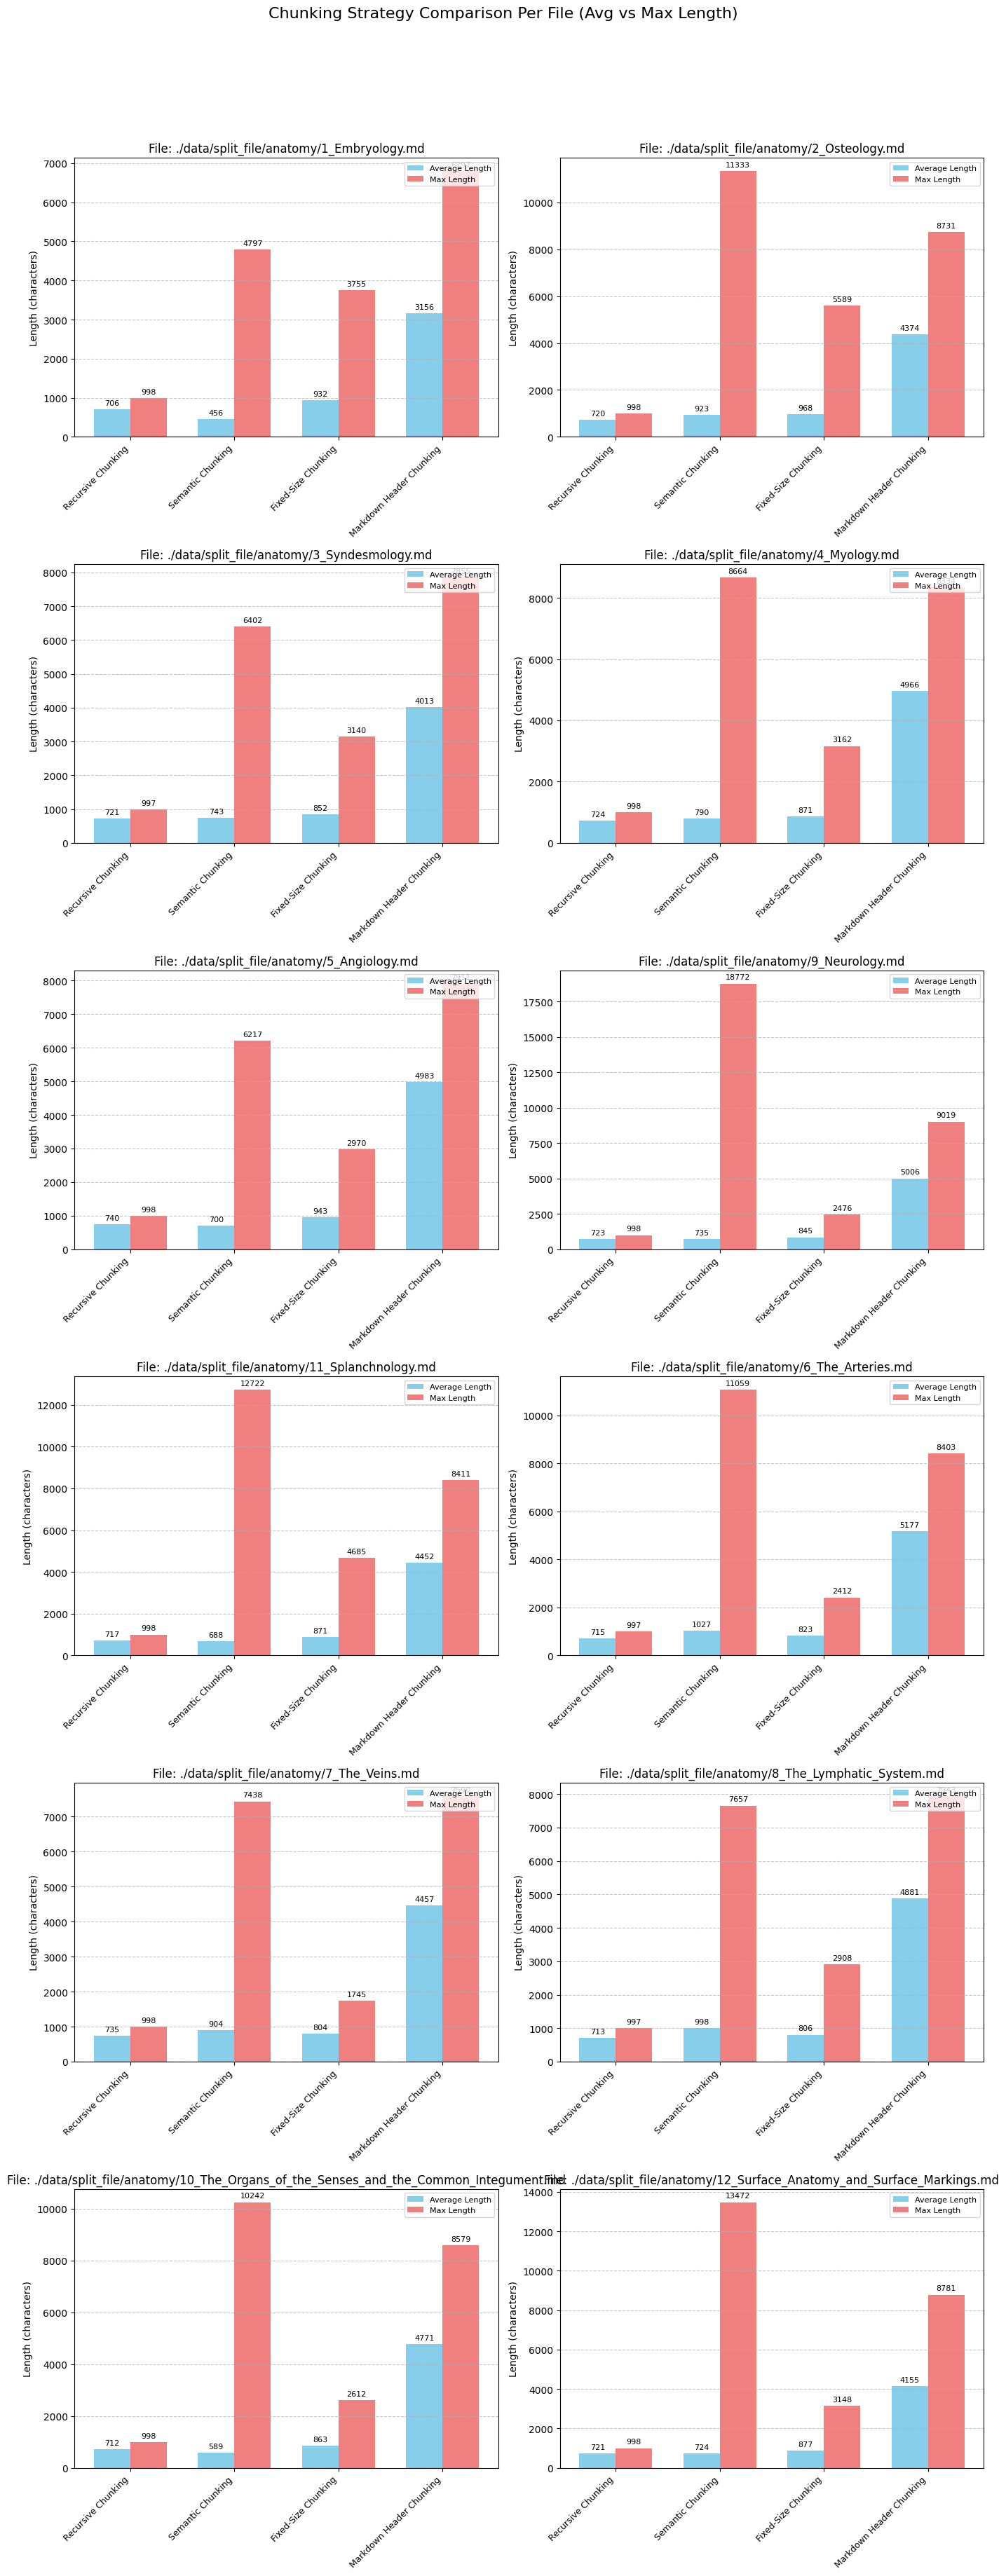

/opt/conda/envs/sangwon/lib/python3.11/site-packages/ipykernel/kernelbase.py:442: RuntimeWarning: coroutine 'InteractiveShell.run_cell_async' was never awaited
  self.log.error("KeyboardInterrupt caught in kernel.")


: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List
# Document 타입을 사용하려면 langchain_core.documents에서 임포트가 필요합니다.
try:
    from langchain_core.documents import Document
except ImportError:
    print("Warning: 'langchain_core' not found. Document type analysis might not work as expected.")
    class Document: # Mock Document class for execution if langchain_core is missing
        def __init__(self, page_content: str, metadata: dict = None):
            self.page_content = page_content
            self.metadata = metadata if metadata is not None else {}

# 한글 폰트 설정 제거: 영어로만 시각화하므로 필요 없습니다.

# --- 1. 파일 로드 및 준비 (이전 셀에서 이미 실행되었다고 가정) ---
# 이 부분은 이전 셀에서 이미 실행되어 all_md_contents 변수가 채워졌다고 가정합니다.
# 만약 이 셀만 단독으로 실행해야 한다면, 아래 주석 처리된 코드를 활성화해야 합니다.
#
# import os
# import re
# import torch
# from langchain_text_splitters import (
#     RecursiveCharacterTextSplitter, CharacterTextSplitter, MarkdownHeaderTextSplitter, MarkdownTextSplitter
# )
# from sentence_transformers import SentenceTransformer, util # 의미론적 청킹에 필요
#
# # 임시 파일 생성 함수 (실제 사용 시 제거)
# def create_dummy_files(directory_path: str):
#     os.makedirs(directory_path, exist_ok=True)
#     sample_content1 = "# Intro\nThis is content 1.\n\n## Section A\nMore content A."
#     sample_content2 = "# Doc 2\nContent for doc 2."
#     with open(os.path.join(directory_path, "sample_1.md"), "w", encoding="utf-8") as f: f.write(sample_content1)
#     with open(os.path.join(directory_path, "sample_2.md"), "w", encoding="utf-8") as f: f.write(sample_content2)
#
# # 파일 로드 함수 (실제 사용 시 그대로 사용)
# def load_markdown_files(directory_path: str) -> Dict[str, str]:
#     md_files_content = {}
#     if not os.path.exists(directory_path) or not os.listdir(directory_path):
#         print(f"Directory '{directory_path}' not found or empty. Creating dummy files.")
#         create_dummy_files(directory_path)
#     
#     for filename in os.listdir(directory_path):
#         if filename.endswith(".md"):
#             filepath = os.path.join(directory_path, filename)
#             with open(filepath, "r", encoding="utf-8") as f: md_files_content[filename] = f.read()
#     return md_files_content
#
# MD_FILES_DIR = "./data/split_file/anatomy"
# all_md_contents = load_markdown_files(MD_FILES_DIR)
#
# # 청크 결과 저장 딕셔너리 초기화
# recursive_chunks_results: Dict[str, List[str]] = {}
# semantic_chunks_results: Dict[str, List[str]] = {}
# fixed_chunks_results: Dict[str, List[str]] = {}
# markdown_chunks_results: Dict[str, List[Document]] = {}
# markdown_splitter_chunks_results: Dict[str, List[Document]] = {}
#
# # Semantic Model (필요시 활성화)
# # try:
# #     semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
# # except:
# #     semantic_model = None
#
# # --- 각 청킹 전략 함수 (이전 셀에서 정의되었다고 가정) ---
# # def recursive_chunking(...): ...
# # def semantic_chunking(...): ...
# # def fixed_size_chunking(...): ...
# # def markdown_header_chunking(...): ...
# # def markdown_text_splitter_chunking_v2(...): ...
#
# # --- 각 청킹 전략 실행 및 결과 저장 (이전 셀에서 실행되었다고 가정) ---
# # for filename, content in all_md_contents.items():
# #     recursive_chunks_results[filename] = recursive_chunking(content)
# #     fixed_chunks_results[filename] = fixed_size_chunking(content)
# #     if semantic_model: semantic_chunks_results[filename] = semantic_chunking(content, semantic_model)
# #     markdown_chunks_results[filename] = markdown_header_chunking(content)
# #     markdown_splitter_chunks_results[filename] = markdown_text_splitter_chunking_v2(content)

# --- 2. 통합 시각화 함수 ---

def plot_all_chunking_results_in_grid(
    all_strategies_data: Dict[str, Dict[str, Dict[str, float]]], # strategy_name: {filename: {avg_len, max_len}}
    file_names: List[str]
):
    """
    모든 청킹 전략과 파일에 대한 결과를 격자 형태로 시각화합니다.
    Args:
        all_strategies_data (Dict[str, Dict[str, Dict[str, float]]]):
            { 'Strategy Name': { 'filename': {'avg_length': val, 'max_length': val} } }
        file_names (List[str]): 분석할 모든 파일 이름 리스트.
    """
    if not all_strategies_data or not file_names:
        print("No data or file names provided for grid plotting.")
        return

    num_strategies = len(all_strategies_data)
    num_files = len(file_names)

    # Calculate grid dimensions (e.g., 2 rows, N columns or N rows, 2 columns)
    # Let's try to make it visually appealing, e.g., 2 files per row
    cols = 2 # Number of columns in the grid
    rows = (num_files + cols - 1) // cols # Calculate required rows
    
    # Create a figure with a subplot grid
    # Each subplot will show all strategies for a single file
    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 6 * rows), squeeze=False) # Ensure axes is always 2D
    axes_flat = axes.flatten() # Flatten the 2D array of axes for easier iteration

    for i, filename in enumerate(file_names):
        ax = axes_flat[i] # Get the current subplot axis

        strategy_labels = []
        avg_lengths = []
        max_lengths = []

        # Collect data for the current file across all strategies
        for strategy_name, strategy_results in all_strategies_data.items():
            if filename in strategy_results:
                stats = strategy_results[filename]
                strategy_labels.append(strategy_name)
                avg_lengths.append(stats['avg_length'])
                max_lengths.append(stats['max_length'])
            # else: # If a strategy didn't process this file, add placeholder
            #     strategy_labels.append(strategy_name)
            #     avg_lengths.append(0)
            #     max_lengths.append(0)

        if not strategy_labels: # Skip if no data for this file across any strategy
            ax.set_visible(False) # Hide unused subplots
            continue

        x = np.arange(len(strategy_labels))
        width = 0.35

        # Bar for Average Length
        rects1 = ax.bar(x - width/2, avg_lengths, width, label='Average Length', color='skyblue')
        # Bar for Max Length
        rects2 = ax.bar(x + width/2, max_lengths, width, label='Max Length', color='lightcoral')

        ax.set_ylabel('Length (characters)', fontsize=10)
        ax.set_title(f'File: {filename}', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(strategy_labels, rotation=45, ha="right", fontsize=9)
        
        ax.bar_label(rects1, padding=3, fmt='%.0f', fontsize=8) # Average length as integer for clarity
        ax.bar_label(rects2, padding=3, fmt='%.0f', fontsize=8) # Max length as integer for clarity

        ax.legend(loc='upper right', fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.7) # Add grid for better readability

    # Hide any unused subplots if num_files is not a multiple of cols
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.suptitle('Chunking Strategy Comparison Per File (Avg vs Max Length)', fontsize=16, y=1.02) # Overall title
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for suptitle
    plt.show()


# --- 3. 데이터 수집 및 시각화 ---

# `analyze_chunks` 함수는 이제 통계 출력과 함께 각 파일별 평균/최대 길이를 반환하지 않습니다.
# 대신, 모든 전략에 대한 데이터를 먼저 수집하고, `plot_all_chunking_results_in_grid` 함수에 전달합니다.

# `collect_analysis_data` 함수는 그대로 사용합니다.
def collect_analysis_data_for_plotting(chunks_dict: Dict[str, List[any]]) -> Dict[str, Dict[str, float]]:
    """
    각 파일의 청크 결과를 분석하여 파일별 평균 및 최대 길이를 반환합니다.
    Args:
        chunks_dict (Dict[str, List[any]]): 파일 이름별 청크 리스트 딕셔너리.
    Returns:
        Dict[str, Dict[str, float]]: { 'filename': {'avg_length': val, 'max_length': val} }
    """
    per_file_data = {}
    if not chunks_dict:
        return per_file_data

    for filename, chunks in chunks_dict.items():
        num_chunks = len(chunks)
        
        file_total_len = 0
        file_min_len = 0
        file_max_len = 0

        if chunks:
            if isinstance(chunks[0], Document):
                file_total_len = sum(len(c.page_content) for c in chunks)
                file_min_len = min(len(c.page_content) for c in chunks)
                file_max_len = max(len(c.page_content) for c in chunks)
            elif isinstance(chunks[0], str):
                file_total_len = sum(len(c) for c in chunks)
                file_min_len = min(len(c) for c in chunks)
                file_max_len = max(len(c) for c in chunks)
        
        file_avg_len = file_total_len / num_chunks if num_chunks > 0 else 0
        
        per_file_data[filename] = {
            'avg_length': file_avg_len,
            'max_length': file_max_len
        }
    return per_file_data


# --- 주요 실행 블록 ---
# 이전에 정의된 `all_md_contents` 및 각 청킹 전략별 `_chunks_results` 변수들이
# 모두 정의되어 있어야 합니다. (이전 셀들을 먼저 실행해주세요.)

# 모든 전략에 대한 데이터를 수집합니다.
all_strategies_aggregated_data = {}

# 재귀적 청킹
if 'recursive_chunks_results' in locals() and recursive_chunks_results:
    analyze_chunks(recursive_chunks_results, "Recursive Chunking", plot_results=False) # 통계만 출력
    all_strategies_aggregated_data["Recursive Chunking"] = collect_analysis_data_for_plotting(recursive_chunks_results)

# 의미론적 청킹
if 'semantic_chunks_results' in locals() and semantic_chunks_results:
    analyze_chunks(semantic_chunks_results, "Semantic Chunking", plot_results=False)
    all_strategies_aggregated_data["Semantic Chunking"] = collect_analysis_data_for_plotting(semantic_chunks_results)

# 고정 크기 청킹
if 'fixed_chunks_results' in locals() and fixed_chunks_results:
    analyze_chunks(fixed_chunks_results, "Fixed-Size Chunking", plot_results=False)
    all_strategies_aggregated_data["Fixed-Size Chunking"] = collect_analysis_data_for_plotting(fixed_chunks_results)

# 마크다운 헤더 청킹 (MarkdownHeaderTextSplitter)
if 'markdown_chunks_results' in locals() and markdown_chunks_results:
    analyze_chunks(markdown_chunks_results, "Markdown Header Chunking", plot_results=False)
    all_strategies_aggregated_data["Markdown Header Chunking"] = collect_analysis_data_for_plotting(markdown_chunks_results)

# MarkdownTextSplitter 청킹
if 'markdown_splitter_chunks_results' in locals() and markdown_splitter_chunks_results:
    analyze_chunks(markdown_splitter_chunks_results, "MarkdownTextSplitter Chunking", plot_results=False)
    all_strategies_aggregated_data["MarkdownTextSplitter Chunking"] = collect_analysis_data_for_plotting(markdown_splitter_chunks_results)


# 모든 파일 이름 리스트 가져오기 (any chunks_dict will do, or all_md_contents keys)
all_file_names = list(all_md_contents.keys()) if 'all_md_contents' in locals() else []
if not all_file_names:
    # Fallback if all_md_contents is not defined (e.g., when running this cell standalone with dummy data)
    # Collect all unique filenames from the aggregated data
    for strategy_data in all_strategies_aggregated_data.values():
        all_file_names.extend(list(strategy_data.keys()))
    all_file_names = sorted(list(set(all_file_names)))


# 모든 파일과 전략에 대한 격자 그래프 출력
plot_all_chunking_results_in_grid(all_strategies_aggregated_data, all_file_names)

In [ ]:
import os
from collections import Counter
import spacy

def extract_and_sort_named_entities(folder_path):
    try:
        nlp = spacy.load("ko_core_news_sm")
    except OSError:
        print("한국어 spaCy 모델 'ko_core_news_sm'을 찾을 수 없습니다.")
        print("다음 명령어를 실행하여 모델을 다운로드해주세요:")
        print("python -m spacy download ko_core_news_sm")
        return []

    entity_counts = Counter()
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".md"):
            filepath = os.path.join(folder_path, filename)
            with open(filepath, 'r', encoding='utf-8') as f:
                content = f.read()
                
                doc = nlp(content)
                
                for ent in doc.ents:
                    entity_counts[ent.text.strip()] += 1 

    sorted_entities = sorted(entity_counts.items(), key=lambda item: item[1], reverse=True)
    
    return sorted_entities

folder_path = "./data/split_file/anatomy"
sorted_entities = extract_and_sort_named_entities(folder_path)

if sorted_entities:
    print(f"'{folder_path}' 폴더의 .md 파일에서 추출된 개체 및 등장 횟수 (내림차순):")
    for entity, count in sorted_entities:
        print(f"'{entity}': {count}회")
else:
    print("추출된 개체가 없거나 폴더를 찾을 수 없습니다.")

'./data/split_file/anatomy' 폴더의 .md 파일에서 추출된 개체 및 등장 횟수 (내림차순):
'and': 22586회
'is': 10302회
'are': 5141회
'a': 3040회
'lower': 1230회
'Fig': 1164회
'artery': 1131회
'surface': 1056회
'at': 1009회
'its': 958회
'middle': 817회
'anterior': 689회
'forward': 657회
'FIG': 642회
'each': 627회
'above': 614회
'also': 495회
'Its': 471회
'being': 441회
'bone': 441회
'canal': 427회
'upward': 419회
'1': 345회
'2': 344회
'attachment': 344회
'cavity': 337회
'layer': 333회
'second': 326회
'about': 324회
'an': 291회
'common': 290회
'3': 287회
'back': 286회
'level': 280회
'lateralward': 276회
'articular': 276회
'angle': 263회
'across': 262회
'latter': 261회
'membrane': 258회
'large': 237회
'length': 237회
'branch': 236회
'Flexor': 234회
'fibrous': 232회
'long': 228회
'surfaces': 220회
'Each': 219회
'apex': 214회
'In the': 214회
'arch': 210회
'like': 204회
'arise': 202회
'area': 197회
'ascending': 192회
'4': 184회
'lesser': 178회
'neck': 173회
'medulla': 171회
'fibers': 168회
'lacrimal': 157회
'appearance': 152회
'arteries': 151회
'aorta': 151회
'continuous': 149회
'

In [ ]:
import os
import json
import torch
from model_loader.config import generation_loader
from model_loader.local_loader import LocalModelLoader
from model_loader.ollama_loader import OllamaModelLoader


def extract_entities_and_relations_with_llm(text_to_analyze):
    if isinstance(generation_loader, LocalModelLoader):
        llm_model = generation_loader.model
        llm_tokenizer = generation_loader.tokenizer
        
        if llm_model is None or llm_tokenizer is None:
            print("경고: LocalModelLoader: LLM 모델 또는 토크나이저가 model_loader/config.py에서 제대로 로드되지 않았습니다.")
            return None, None

        try:
            llm_model.eval()
            print("LocalModelLoader 인스턴스 사용 준비 완료.")
        except Exception as e:
            print(f"LocalModelLoader 인스턴스 설정 중 오류 발생: {e}")
            return None, None
            
        is_local_model = True

    elif isinstance(generation_loader, OllamaModelLoader):
        print("OllamaModelLoader 인스턴스 사용 준비 완료.")
        is_local_model = False 

    else:
        print("오류: 지원하지 않는 모델 로더 타입입니다. (LocalModelLoader 또는 OllamaModelLoader여야 합니다.)")
        return None, None


    prompt = f"""다음 문장에서 엔티티와 그들 간의 관계를 추출해줘.
엔티티는 고유한 명사나 개념이어야 하며, 가능한 한 명사형으로 추출해줘. 복합적인 활동이나 현상보다는 구체적인 사물이나 개념을 엔티티로 식별해.
관계는 두 엔티티 사이의 연결을 명확하게 설명하고, 지식 그래프의 재사용 가능한 관계 동사(predicate)를 선호해. 관계 동사는 간결한 동사 또는 '의_부분', '을_포함'과 같이 하이픈으로 연결된 명확한 형태로 사용해줘.
다음과 같은 구체적이고 간결한 관계 동사를 사용해:
- 'X는 Y를 통해 순환한다' -> '순환한다_통해'
- 'X는 Y를 공급한다' -> '공급한다'
- 'X는 Y의 부분이다' -> '의_부분'
- 'X는 Y를 유발한다' -> '유발한다'
- 'X는 Y를 생성한다' -> '생성한다'
- 'X는 Y에 존재한다' -> '에_존재'
- 'X는 Y의 중심 기관이다' -> '의_중심_기관'
- 'X는 Y를 조절한다' -> '조절한다'
- 'X는 Y에 의해 발생한다' -> '에_의해_발생'
- 'X는 Y를 매개한다' -> '매개한다'

서술적이거나 모호한 관계(예: 'X는 Y와 관련있다', 'X는 Y를 담당한다', 'X는 Y를 한다', 'X는 Y에 중요한 역할을 한다')는 피하고, 더 명확한 관계로 변환해줘.
결과는 오직 다음 JSON 형식으로만 출력하고, 다른 설명이나 텍스트는 포함하지 마:
{{
    "entities": [
        {{"name": "엔티티1", "type": "유형 (예: 기관, 시스템, 물질, 기능, 질병)"}},
        {{"name": "엔티티2", "type": "유형"}}
    ],
    "relations": [
        {{"head": "엔티티1", "relation": "관계 유형 (예: 의_부분, 유발한다)", "tail": "엔티티2"}},
        {{"head": "엔티티3", "relation": "생성한다", "tail": "엔티티4"}}
    ]
}}

- 좋은 예시
문장: "심장은 순환계의 중심 기관이며, 혈액을 온몸으로 펌프질한다."
JSON 결과:
{{
    "entities": [
        {{"name": "심장", "type": "기관"}},
        {{"name": "순환계", "type": "시스템"}},
        {{"name": "혈액", "type": "물질"}},
        {{"name": "몸", "type": "해부학적_구조"}}
    ],
    "relations": [
        {{"head": "심장", "relation": "의_중심_기관", "tail": "순환계"}},
        {{"head": "심장", "relation": "펌프질하여_순환시킨다", "tail": "혈액"}},
        {{"head": "혈액", "relation": "순환한다_통해", "tail": "몸"}}
    ]
}}

- 나쁜 예시 (이렇게 하지 마세요)
문장: "폐는 호흡계의 주요 기관으로, 산소와 이산화탄소 교환을 담당한다."
JSON 결과:

{{
    "entities": [
        {{"name": "폐", "type": "기관"}},
        {{"name": "호흡계", "type": "시스템"}},
        {{"name": "산소와 이산화탄소 교환", "type": "활동"}}
    ],
    "relations": [
        {{"head": "폐", "relation": "담당한다", "tail": "산소와 이산화탄소 교환"}},
        {{"head": "폐", "relation": "의_부분이다", "tail": "호흡계"}}
    ]
}}
(설명: '산소와 이산화탄소 교환'은 명사형 엔티티로 부적합하며, '담당한다'는 너무 서술적입니다. '폐는 산소와 이산화탄소를 교환한다'와 같이 더 구체적인 엔티티와 관계로 분리하는 것이 좋습니다.)
문장: "{text_to_analyze}"
JSON 결과:
"""

    print("LLM 추론 시작...")
    
    generated_text = ""
    if is_local_model:
        inputs = llm_tokenizer(prompt, return_tensors="pt").to(llm_model.device)
        max_new_tokens = 512 
        
        with torch.no_grad():
            outputs = llm_model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_return_sequences=1,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                repetition_penalty=1.2,
                eos_token_id=llm_tokenizer.eos_token_id
            )
        generated_text = llm_tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    else:
        generated_text = generation_loader.generate(prompt) 

    print("LLM 추론 완료.")
    print("\n--- LLM 원본 출력 ---")
    print(generated_text)
    print("---------------------\n")

    try:
        json_start = generated_text.find('{')
        json_end = generated_text.rfind('}') + 1

        if json_start != -1 and json_end != -1 and json_end > json_start:
            json_str = generated_text[json_start:json_end]
            parsed_result = json.loads(json_str.strip())

            extracted_entities = parsed_result.get("entities", [])
            extracted_relations = parsed_result.get("relations", [])

            return extracted_entities, extracted_relations
        else:
            print("경고: LLM 출력에서 유효한 JSON을 찾을 수 없습니다.")
            return None, None
    except json.JSONDecodeError as e:
        print(f"JSON 파싱 오류: {e}")
        print("LLM이 생성한 JSON 형식이 올바르지 않을 수 있습니다.")
        return None, None
    except Exception as e:
        print(f"결과 파싱 중 알 수 없는 오류 발생: {e}")
        return None, None

if __name__ == "__main__":
    test_sentences = [
        "심장은 순환계의 중심 기관으로, 혈액을 온몸으로 펌프질한다.", 
        "폐는 호흡계의 주요 기관으로, 산소와 이산화탄소 교환을 담당한다.", 
        "췌장은 소화와 혈당 조절에 중요한 역할을 하는 내분비선이다.",
        "척수는 중추신경계의 일부로, 뇌와 신체 사이의 신호 전달을 매개한다.",
        "코로나19는 바이러스에 의해 발생하며, 발열과 기침이 주요 증상이다.",
        "세종대왕은 조선의 4대 왕이며, 한글을 창제하였다.",
        "서울은 대한민국의 수도이며, 한강이 흐른다.",
        "독도는 한국의 영토이며, 천연기념물로 지정되어 있다.",
        "이 약물은 암세포의 성장을 억제하여 치료 효과를 나타낸다.",
        "간은 해독 작용을 하며, 담즙을 생산한다.",
        "인슐린은 췌장의 랑게르한스 섬에서 생성되어 혈액으로 분비된다.",
        "백신 접종은 감염병을 예방하며, 집단 면역 형성에 기여한다.",
        "뇌졸중은 뇌 혈류 장애로 인해 발생하며, 운동 기능 마비를 유발할 수 있다.",
        "광합성은 식물 잎에서 일어나며, 태양 에너지를 사용하여 포도당과 산소를 생성한다."
    ]

    for i, sentence in enumerate(test_sentences):
        print(f"\n--- 실험 {i+1}: 문장 '{sentence}' ---")
        entities, relations = extract_entities_and_relations_with_llm(sentence)

        if entities is not None and relations is not None:
            print("\n추출된 엔티티:")
            if entities:
                for ent in entities:
                    print(f"  - 이름: {ent.get('name')}, 유형: {ent.get('type')}")
            else:
                print("엔티티가 추출되지 않았습니다.")

            print("\n추출된 관계:")
            if relations:
                for rel in relations:
                    print(f"  - {rel.get('head')} --({rel.get('relation')})--> {rel.get('tail')}")
            else:
                print("관계가 추출되지 않았습니다.")
        print("\n" + "="*50 + "\n")

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



--- 실험 1: 문장 '심장은 순환계의 중심 기관으로, 혈액을 온몸으로 펌프질한다.' ---
OllamaModelLoader 인스턴스 사용 준비 완료.
LLM 추론 시작...
LLM 추론 완료.

--- LLM 원본 출력 ---
```json
{
    "entities": [
        {"name": "심장", "type": "기관"},
        {"name": "순환계", "type": "시스템"},
        {"name": "혈액", "type": "물질"},
        {"name": "몸", "type": "해부학적_구조"}
    ],
    "relations": [
        {"head": "심장", "relation": "의_중심_기관", "tail": "순환계"},
        {"head": "심장", "relation": "펌프질한다", "tail": "혈액"},
        {"head": "혈액", "relation": "순환한다_통해", "tail": "몸"}
    ]
}
```
---------------------


추출된 엔티티:
  - 이름: 심장, 유형: 기관
  - 이름: 순환계, 유형: 시스템
  - 이름: 혈액, 유형: 물질
  - 이름: 몸, 유형: 해부학적_구조

추출된 관계:
  - 심장 --(의_중심_기관)--> 순환계
  - 심장 --(펌프질한다)--> 혈액
  - 혈액 --(순환한다_통해)--> 몸



--- 실험 2: 문장 '폐는 호흡계의 주요 기관으로, 산소와 이산화탄소 교환을 담당한다.' ---
OllamaModelLoader 인스턴스 사용 준비 완료.
LLM 추론 시작...
LLM 추론 완료.

--- LLM 원본 출력 ---
```json
{
    "entities": [
        {"name": "폐", "type": "기관"},
        {"name": "호흡계", "type": "시스템"},
        {"name": "산소", "type":